# Data Files

In [1]:
train_file = r'.\aps_failure_train.csv'
test_file = r'.\aps_failure_test.csv'

# Import Dependencies

In [2]:
import pandas as pd

import numpy as np
from numpy.random import seed

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from keras.utils import to_categorical
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow

from xgboost import XGBRFClassifier
from xgboost import XGBClassifier

from catboost import CatBoostClassifier

seed(42)
tensorflow.random.set_seed(42)

Using TensorFlow backend.


# Scoring Function

In [3]:
def my_cost(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return -np.log((fn*3500) + (fp*100))

scorer = make_scorer(my_cost, greater_is_better=True)

# Explore Data

Class 0: 55968
Class 1: 1032
Proportion: 54.23 : 1
56424


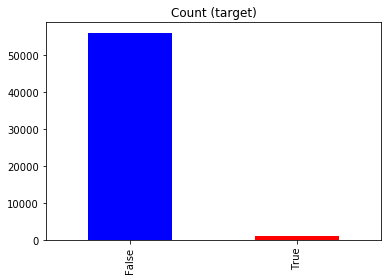

In [4]:
df_check = pd.read_csv(train_file,header = 0)

target_count = df_check['class'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)', color=("b","r"));

print(df_check.shape[0] - df_check.dropna().shape[0])

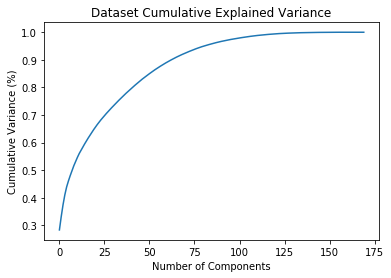

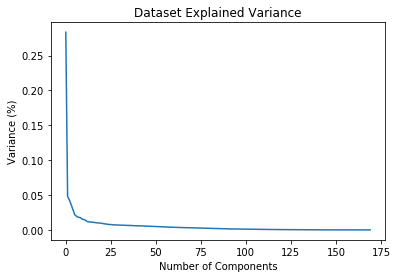

In [6]:
df = pd.read_csv(train_file)
X = df.drop('class', axis = 1).values
y = df['class'].values.astype(int)

imp = SimpleImputer(strategy = "median")
X_exp = imp.fit_transform(X)

scal = StandardScaler()
X_exp = scal.fit_transform(X_exp)

pca = PCA().fit(X_exp)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('Dataset Cumulative Explained Variance')

plt.figure()
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Dataset Explained Variance')

plt.show()

# Import Training Data and Split in Train and Validation

In [7]:
df = pd.read_csv(train_file)
X = df.drop('class', axis = 1).values
y = df['class'].values.astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Import Testing Data

In [8]:
df_test = pd.read_csv(test_file)
X_test = df_test.drop('class', axis = 1).values

# Build Model Pipelines, 3-Fold Crossvalidation on Train Set
# Validation on Validation Split Set
# Finally, Train on full data, predict on test data, generate output

### Random Forest Crossvalidation, Validation Set Scores and Test Set Predictions

In [12]:
pipeRandFor = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('RandFor', RandomForestClassifier(n_estimators=30,max_depth=9,random_state=42,
                                       n_jobs=-1, class_weight='balanced_subsample'))
])

cvsRandFor = cross_val_score(pipeRandFor, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1)
print(cvsRandFor)

[-12.02574909 -11.86779879 -12.00334428]


In [13]:
pipeRandFor.fit(X_train, y_train)

y_pred_RandFor = pipeRandFor.predict(X_val)

print(confusion_matrix(y_val, y_pred_RandFor))
print(my_cost(y_val, y_pred_RandFor))

[[13643   349]
 [   14   244]]
-11.337380892455297


In [14]:
pipeRandFor.fit(X,y)

y_pred_RandFor = pipeRandFor.predict(X_test)

out_RandFor = pd.DataFrame(y_pred_RandFor.astype(bool))
out_RandFor.index = np.arange(1,len(out_RandFor)+1)
out_RandFor.to_csv("out_RandFor.csv", header=['Predicted'], index = True, index_label="Id")

### Support Vector Machine Crossvalidation, Validation Set Scores and Test Set Predictions

In [15]:
pipeSVC = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scal', StandardScaler()),
    ('pca', PCA(n_components=90, random_state=42)),
    ('svc', SVC(random_state=42, gamma = 0.01, C = 0.1,
                verbose = True, class_weight='balanced',cache_size = 1000))
])

cvsSVC = cross_val_score(pipeSVC, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1)
print(cvsSVC)

[-11.65875591 -11.65702581 -11.67078355]


In [16]:
pipeSVC.fit(X_train, y_train)

y_pred_SVC = pipeSVC.predict(X_val)

print(confusion_matrix(y_val, y_pred_SVC))
print(my_cost(y_val, y_pred_SVC))

[LibSVM][[13362   630]
 [    8   250]]
-11.418614785498987


In [17]:
pipeSVC.fit(X,y)

y_pred_SVC = pipeSVC.predict(X_test)

out_SVC = pd.DataFrame(y_pred_SVC.astype(bool))
out_SVC.index = np.arange(1,len(out_SVC)+1)
out_SVC.to_csv("out_SVC.csv", header=['Predicted'], index = True, index_label="Id")

[LibSVM]

### XGBoost Crossvalidation, Validation Set Scores and Test Set Predictions

In [18]:
pipeXGB = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scal', StandardScaler()),
    ('pca', PCA(n_components=90, random_state=42)),
    ('XGB', XGBClassifier(n_estimators=100, max_depth=4, random_state=42,
                          n_jobs=-1, scale_pos_weight=54, gamma = 0.01, reg_lambda=0.1, reg_alpha=0.1))
])

cvsXGB = cross_val_score(pipeXGB, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1)
print(cvsXGB)

[-11.95697006 -11.89273083 -12.00211879]


In [19]:
pipeXGB.fit(X_train, y_train)

y_pred_XGB = pipeXGB.predict(X_val)

print(confusion_matrix(y_val, y_pred_XGB))
print(my_cost(y_val, y_pred_XGB))

[[13685   307]
 [   20   238]]
-11.519901078706654


In [20]:
pipeXGB.fit(X,y)

y_pred_XGB = pipeXGB.predict(X_test)

out_XGB = pd.DataFrame(y_pred_XGB.astype(bool))
out_XGB.index = np.arange(1,len(out_XGB)+1)
out_XGB.to_csv("out_XGB.csv", header=['Predicted'], index = True, index_label="Id")

### XGBoost Random Forest Crossvalidation, Validation Set Scores and Test Set Predictions

In [21]:
pipeXGBRandFor = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('XGBRandFor', XGBRFClassifier(max_depth=6, n_estimators=50, n_jobs=-1, random_state=42,
                                   scale_pos_weight = 54, reg_alpha = 0.1, reg_lambda=0.1, gamma = 1))
])

cvsXGBRandFor = cross_val_score(pipeXGBRandFor, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1)
print(cvsXGBRandFor)

[-11.72237569 -11.69524702 -11.79131449]


In [22]:
pipeXGBRandFor.fit(X_train, y_train)

y_pred_XGBRandFor = pipeXGBRandFor.predict(X_val)

print(confusion_matrix(y_val, y_pred_XGBRandFor))
print(my_cost(y_val, y_pred_XGBRandFor))

[[13492   500]
 [   12   246]]
-11.429543856031177


In [23]:
pipeXGBRandFor.fit(X,y)

y_pred_XGBRandFor = pipeXGBRandFor.predict(X_test)

out_XGBRandFor = pd.DataFrame(y_pred_XGBRandFor.astype(bool))
out_XGBRandFor.index = np.arange(1,len(out_XGBRandFor)+1)
out_XGBRandFor.to_csv("out_XGBRandFor.csv", header=['Predicted'], index = True, index_label="Id")

### CatBoost Crossvalidation, Validation Set Scores and Test Set Predictions

In [24]:
pipeCat = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scal', StandardScaler()),
    ('cat', CatBoostClassifier(iterations=500, learning_rate=0.01, l2_leaf_reg=3.5, depth=10,
                               rsm=0.98, loss_function= 'Logloss', eval_metric='AUC',
                               scale_pos_weight=54, random_seed=42, early_stopping_rounds=10))
])

cvsCat = cross_val_score(pipeCat, X_train, y_train, cv=3, scoring=scorer, n_jobs=-1)
print(cvsCat)

[         nan          nan -11.49374265]


In [25]:
pipeCat.fit(X_train, y_train)

y_pred_Cat = pipeCat.predict(X_val)

print(confusion_matrix(y_val, y_pred_Cat))
print(my_cost(y_val, y_pred_Cat))

0:	total: 853ms	remaining: 7m 5s
1:	total: 1.53s	remaining: 6m 21s
2:	total: 2.26s	remaining: 6m 14s
3:	total: 2.99s	remaining: 6m 10s
4:	total: 3.66s	remaining: 6m 2s
5:	total: 4.34s	remaining: 5m 57s
6:	total: 5.01s	remaining: 5m 53s
7:	total: 5.7s	remaining: 5m 50s
8:	total: 6.37s	remaining: 5m 47s
9:	total: 7.05s	remaining: 5m 45s
10:	total: 7.73s	remaining: 5m 43s
11:	total: 8.4s	remaining: 5m 41s
12:	total: 9.16s	remaining: 5m 43s
13:	total: 9.88s	remaining: 5m 43s
14:	total: 10.7s	remaining: 5m 44s
15:	total: 11.4s	remaining: 5m 43s
16:	total: 12s	remaining: 5m 41s
17:	total: 12.8s	remaining: 5m 42s
18:	total: 13.6s	remaining: 5m 44s
19:	total: 14.3s	remaining: 5m 43s
20:	total: 15s	remaining: 5m 43s
21:	total: 15.7s	remaining: 5m 41s
22:	total: 16.4s	remaining: 5m 40s
23:	total: 17.1s	remaining: 5m 38s
24:	total: 17.8s	remaining: 5m 38s
25:	total: 18.5s	remaining: 5m 37s
26:	total: 19.3s	remaining: 5m 37s
27:	total: 20.1s	remaining: 5m 38s
28:	total: 21s	remaining: 5m 40s
29:	t

230:	total: 2m 46s	remaining: 3m 13s
231:	total: 2m 47s	remaining: 3m 13s
232:	total: 2m 47s	remaining: 3m 12s
233:	total: 2m 48s	remaining: 3m 11s
234:	total: 2m 49s	remaining: 3m 10s
235:	total: 2m 49s	remaining: 3m 10s
236:	total: 2m 50s	remaining: 3m 9s
237:	total: 2m 51s	remaining: 3m 8s
238:	total: 2m 51s	remaining: 3m 7s
239:	total: 2m 52s	remaining: 3m 7s
240:	total: 2m 53s	remaining: 3m 6s
241:	total: 2m 54s	remaining: 3m 5s
242:	total: 2m 54s	remaining: 3m 4s
243:	total: 2m 55s	remaining: 3m 4s
244:	total: 2m 56s	remaining: 3m 3s
245:	total: 2m 56s	remaining: 3m 2s
246:	total: 2m 57s	remaining: 3m 1s
247:	total: 2m 58s	remaining: 3m 1s
248:	total: 2m 59s	remaining: 3m
249:	total: 2m 59s	remaining: 2m 59s
250:	total: 3m	remaining: 2m 59s
251:	total: 3m 1s	remaining: 2m 58s
252:	total: 3m 1s	remaining: 2m 57s
253:	total: 3m 2s	remaining: 2m 56s
254:	total: 3m 3s	remaining: 2m 55s
255:	total: 3m 3s	remaining: 2m 55s
256:	total: 3m 4s	remaining: 2m 54s
257:	total: 3m 5s	remaining

456:	total: 5m 23s	remaining: 30.5s
457:	total: 5m 24s	remaining: 29.8s
458:	total: 5m 25s	remaining: 29.1s
459:	total: 5m 26s	remaining: 28.3s
460:	total: 5m 26s	remaining: 27.6s
461:	total: 5m 27s	remaining: 26.9s
462:	total: 5m 28s	remaining: 26.2s
463:	total: 5m 28s	remaining: 25.5s
464:	total: 5m 29s	remaining: 24.8s
465:	total: 5m 30s	remaining: 24.1s
466:	total: 5m 30s	remaining: 23.4s
467:	total: 5m 31s	remaining: 22.7s
468:	total: 5m 32s	remaining: 21.9s
469:	total: 5m 32s	remaining: 21.2s
470:	total: 5m 33s	remaining: 20.5s
471:	total: 5m 34s	remaining: 19.8s
472:	total: 5m 34s	remaining: 19.1s
473:	total: 5m 35s	remaining: 18.4s
474:	total: 5m 36s	remaining: 17.7s
475:	total: 5m 36s	remaining: 17s
476:	total: 5m 37s	remaining: 16.3s
477:	total: 5m 38s	remaining: 15.6s
478:	total: 5m 38s	remaining: 14.8s
479:	total: 5m 39s	remaining: 14.1s
480:	total: 5m 40s	remaining: 13.4s
481:	total: 5m 40s	remaining: 12.7s
482:	total: 5m 41s	remaining: 12s
483:	total: 5m 42s	remaining: 11

In [26]:
pipeCat.fit(X,y)

y_pred_Cat = pipeCat.predict(X_test)

out_Cat = pd.DataFrame(y_pred_Cat.astype(bool))
out_Cat.index = np.arange(1,len(out_Cat)+1)
out_Cat.to_csv("out_Cat.csv", header=['Predicted'], index = True, index_label="Id")

0:	total: 690ms	remaining: 5m 44s
1:	total: 1.4s	remaining: 5m 49s
2:	total: 2.09s	remaining: 5m 46s
3:	total: 2.8s	remaining: 5m 47s
4:	total: 3.48s	remaining: 5m 44s
5:	total: 4.17s	remaining: 5m 43s
6:	total: 4.9s	remaining: 5m 45s
7:	total: 5.59s	remaining: 5m 43s
8:	total: 6.29s	remaining: 5m 43s
9:	total: 7.06s	remaining: 5m 45s
10:	total: 7.83s	remaining: 5m 48s
11:	total: 8.57s	remaining: 5m 48s
12:	total: 9.29s	remaining: 5m 48s
13:	total: 10s	remaining: 5m 47s
14:	total: 10.7s	remaining: 5m 47s
15:	total: 11.5s	remaining: 5m 47s
16:	total: 12.3s	remaining: 5m 50s
17:	total: 13.1s	remaining: 5m 49s
18:	total: 13.8s	remaining: 5m 49s
19:	total: 14.5s	remaining: 5m 47s
20:	total: 15.2s	remaining: 5m 46s
21:	total: 15.9s	remaining: 5m 44s
22:	total: 16.6s	remaining: 5m 43s
23:	total: 17.2s	remaining: 5m 41s
24:	total: 17.9s	remaining: 5m 40s
25:	total: 18.6s	remaining: 5m 39s
26:	total: 19.3s	remaining: 5m 38s
27:	total: 20s	remaining: 5m 37s
28:	total: 20.7s	remaining: 5m 36s
29

229:	total: 2m 48s	remaining: 3m 17s
230:	total: 2m 49s	remaining: 3m 17s
231:	total: 2m 49s	remaining: 3m 16s
232:	total: 2m 50s	remaining: 3m 15s
233:	total: 2m 51s	remaining: 3m 14s
234:	total: 2m 52s	remaining: 3m 13s
235:	total: 2m 52s	remaining: 3m 13s
236:	total: 2m 53s	remaining: 3m 12s
237:	total: 2m 54s	remaining: 3m 11s
238:	total: 2m 54s	remaining: 3m 10s
239:	total: 2m 55s	remaining: 3m 10s
240:	total: 2m 56s	remaining: 3m 9s
241:	total: 2m 56s	remaining: 3m 8s
242:	total: 2m 57s	remaining: 3m 7s
243:	total: 2m 58s	remaining: 3m 7s
244:	total: 2m 59s	remaining: 3m 6s
245:	total: 2m 59s	remaining: 3m 5s
246:	total: 3m	remaining: 3m 5s
247:	total: 3m 1s	remaining: 3m 4s
248:	total: 3m 2s	remaining: 3m 3s
249:	total: 3m 2s	remaining: 3m 2s
250:	total: 3m 3s	remaining: 3m 1s
251:	total: 3m 4s	remaining: 3m 1s
252:	total: 3m 4s	remaining: 3m
253:	total: 3m 5s	remaining: 2m 59s
254:	total: 3m 6s	remaining: 2m 59s
255:	total: 3m 7s	remaining: 2m 58s
256:	total: 3m 8s	remaining: 2

455:	total: 5m 32s	remaining: 32s
456:	total: 5m 32s	remaining: 31.3s
457:	total: 5m 33s	remaining: 30.6s
458:	total: 5m 34s	remaining: 29.8s
459:	total: 5m 34s	remaining: 29.1s
460:	total: 5m 35s	remaining: 28.4s
461:	total: 5m 36s	remaining: 27.7s
462:	total: 5m 36s	remaining: 26.9s
463:	total: 5m 37s	remaining: 26.2s
464:	total: 5m 38s	remaining: 25.5s
465:	total: 5m 39s	remaining: 24.7s
466:	total: 5m 39s	remaining: 24s
467:	total: 5m 40s	remaining: 23.3s
468:	total: 5m 41s	remaining: 22.6s
469:	total: 5m 41s	remaining: 21.8s
470:	total: 5m 42s	remaining: 21.1s
471:	total: 5m 43s	remaining: 20.4s
472:	total: 5m 43s	remaining: 19.6s
473:	total: 5m 44s	remaining: 18.9s
474:	total: 5m 45s	remaining: 18.2s
475:	total: 5m 46s	remaining: 17.4s
476:	total: 5m 46s	remaining: 16.7s
477:	total: 5m 47s	remaining: 16s
478:	total: 5m 48s	remaining: 15.3s
479:	total: 5m 48s	remaining: 14.5s
480:	total: 5m 49s	remaining: 13.8s
481:	total: 5m 50s	remaining: 13.1s
482:	total: 5m 50s	remaining: 12.3

### Neural Network

In [9]:
# Define Imputer, Scaler and PCA for Neural Network
y_NN = to_categorical(y)

imp = SimpleImputer(strategy = "median")
X_NN = imp.fit_transform(X)
X_test_NN = imp.transform(X_test)

scal = StandardScaler()
X_NN = scal.fit_transform(X_NN)
X_test_NN = scal.transform(X_test_NN)

pca = PCA(n_components=100, random_state=42)
X_NN = pca.fit_transform(X_NN)
X_test_NN = pca.transform(X_test_NN)

cols = X_NN.shape[1]

model = Sequential()

model.add(Dense(100, activation = 'relu', input_shape = (cols,)))
model.add(Dropout(0.25))
model.add(Dense(50, activation = 'relu'))

model.add(Dense(2, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 15,252
Trainable params: 15,252
Non-trainable params: 0
_________________________________________________________________


In [10]:
class_weight = {0: 1, 1: 54}
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint('project_NN_imputed_median_Normed_PCA.h5',
                           save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_NN, y_NN, validation_split = 0.25,
                    epochs = 100, callbacks = [earlyStopping, mcp_save],
                    batch_size = 64, class_weight=class_weight)

Train on 42750 samples, validate on 14250 samples
Epoch 1/100
42750/42750 [==============================] - 2s 38us/step - loss: 0.5782 - accuracy: 0.9234 - val_loss: 0.3618 - val_accuracy: 0.9543
Epoch 2/100
42750/42750 [==============================] - 1s 31us/step - loss: 0.3317 - accuracy: 0.9529 - val_loss: 0.3236 - val_accuracy: 0.9435
Epoch 3/100
42750/42750 [==============================] - 1s 31us/step - loss: 0.2732 - accuracy: 0.9594 - val_loss: 0.2883 - val_accuracy: 0.9481
Epoch 4/100
42750/42750 [==============================] - 1s 33us/step - loss: 0.2449 - accuracy: 0.9620 - val_loss: 0.2758 - val_accuracy: 0.9519
Epoch 5/100
42750/42750 [==============================] - 1s 31us/step - loss: 0.2169 - accuracy: 0.9649 - val_loss: 0.2921 - val_accuracy: 0.9597
Epoch 6/100
42750/42750 [==============================] - 1s 30us/step - loss: 0.2215 - accuracy: 0.9625 - val_loss: 0.2868 - val_accuracy: 0.9558
Epoch 7/100
42750/42750 [==============================] - 1s 

In [11]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

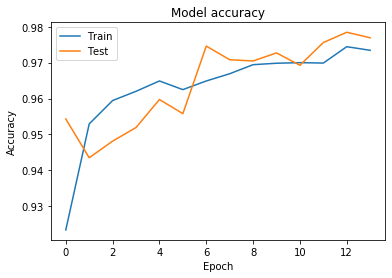

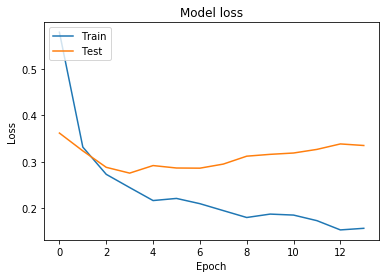

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
best_model = load_model('project_NN_imputed_median_Normed_PCA.h5')

y_pred_NN = best_model.predict(X_test_NN)
out_NN = pd.DataFrame(np.argmax(y_pred_NN, axis=1).astype(bool))
out_NN.index = np.arange(1,len(out_NN)+1)
out_NN.to_csv("out_NN.csv", header=['Predicted'], index = True, index_label="Id")